In [ ]:
# ===================== Museum Heist =====================
# A simple text adventure game using a generic engine API

from text_adventure_games import games, actions, things, blocks

# ---------- Helpers ----------
def connect_locations(src, direction, dest):
    if hasattr(src, "add_exit"):
        src.add_exit(direction, dest)
    elif hasattr(src, "add_connection"):
        src.add_connection(direction, dest)
    elif hasattr(src, "set_exit"):
        src.set_exit(direction, dest)
    else:
        if not hasattr(src, "exits") or not isinstance(getattr(src, "exits"), dict):
            src.exits = {}
        src.exits[direction] = dest

def add_names(item, *names):
    names = [str(n).lower() for n in names]
    if hasattr(item, "nouns"):
        item.nouns = sorted(set(list(getattr(item, "nouns", [])) + names))
    elif hasattr(item, "aliases"):
        item.aliases = sorted(set(list(getattr(item, "aliases", [])) + names))
    elif hasattr(item, "keywords"):
        item.keywords = sorted(set(list(getattr(item, "keywords", [])) + names))
    else:
        item.names = sorted(set(list(getattr(item, "names", [])) + names))

def place_item(loc, item, game=None):
    placed = False
    for meth in ("add_thing","add_item","add_object"):
        if hasattr(loc, meth):
            try:
                getattr(loc, meth)(item); placed = True
            except Exception:
                pass
    if not placed:
        for attr in ("items","things","contents"):
            if hasattr(loc, attr):
                cont = getattr(loc, attr)
                try:
                    if isinstance(cont, dict):
                        cont[item.name] = item; placed = True
                    elif isinstance(cont, list) and item not in cont:
                        cont.append(item); placed = True
                except Exception:
                    pass
    if game is not None and hasattr(game, "parser") and hasattr(game.parser, "register_thing"):
        try: game.parser.register_thing(item)
        except Exception: pass

def robust_has(game, name):
    name = (name or "").lower()
    # our simple bag (some starters)
    if hasattr(game, "inv"):
        for it in game.inv:
            if name == getattr(it, "name", "").lower() or name in set(map(str.lower, getattr(it, "aliases", []) or [])):
                return True
    # engine player containers
    p = getattr(game, "player", None)
    for attr in ("inv","inventory","items","things","contents"):
        if p is not None and hasattr(p, attr):
            cont = getattr(p, attr)
            seq = []
            if isinstance(cont, dict): seq = list(cont.values())
            elif isinstance(cont, (list, tuple, set)): seq = list(cont)
            for it in seq:
                names = {getattr(it, "name", "").lower()}
                for a in ("nouns","aliases","keywords","names"):
                    if hasattr(it, a) and getattr(it, a):
                        names |= {str(v).lower() for v in getattr(it, a)}
                if name in names: return True
    return False

# ---------- World ----------
lobby    = games.Location("Museum Lobby", "A marble hall with brochures and a sleepy night guard.")
gallery  = games.Location("Gallery", "Paintings line the walls. A glass case hums over a glittering diamond.")
security = games.Location("Security Room", "Monitors, a keycard reader, and a huge red POWER switch.")
roof     = games.Location("Roof", "Cold wind. A vent and anchor points for climbing.")
alley    = games.Location("Back Alley", "Your silent getaway van waits in the shadows.")

connect_locations(lobby,   "north", gallery)
connect_locations(gallery, "south", lobby)
connect_locations(lobby,   "east",  security)
connect_locations(security,"west",  lobby)
connect_locations(lobby,   "up",    roof)
connect_locations(roof,    "down",  lobby)
connect_locations(lobby,   "west",  alley)
connect_locations(alley,   "east",  lobby)

# ---------- Items ----------
keycard = things.Item("keycard", "Staff keycard with a magnetic stripe.")
cutter  = things.Item("cutter",  "A glass-cutter tool.")
rope    = things.Item("rope",    "A coiled climbing rope.")
diamond = things.Item("diamond", "The Star of Atria. It sparkles behind glass.")

add_names(keycard, "keycard", "staff keycard", "staff card", "card", "key card")
add_names(cutter,  "cutter", "glass cutter", "glass-cutter", "tool")
add_names(rope,    "rope", "climbing rope")
add_names(diamond, "diamond", "star of atria", "gem", "jewel")

# ---------- Puzzles ----------
class LaserGrid(blocks.Block):
    def __init__(self):
        self.on = True
        self.description = "A web of red lasers bars the way—trip it and the alarm will blare."
    def disable(self):
        self.on = False
        self.description = "The laser grid is offline; faint scorch marks line the floor."
    def is_blocking(self, game, src, direction):
        return self.on and (src is lobby) and (str(direction).lower() == "north")

laser = LaserGrid()

class Vault:
    def __init__(self): self.locked = True
vault = Vault()

# ---------- Game ----------
player = things.Character(name="You", description="", persona="")
try:
    game = games.Game(lobby, player)   # (start_at, player)
except TypeError:
    game = games.Game(player, lobby)   # (player, start_at)

# place items
place_item(lobby,    keycard, game)
place_item(security, cutter,  game)
place_item(roof,     rope,    game)
place_item(gallery,  diamond, game)    # important: diamond is in Gallery

# register movement block
try:
    games.register_block(game, lobby, "north", laser)
except Exception:
    try:
        games.register_block(lobby, "north", laser)
    except Exception:
        if hasattr(game, "register_block"):
            game.register_block(lobby, "north", laser)
        elif hasattr(lobby, "add_block"):
            lobby.add_block("north", laser)

# attach robust has()
game.has = lambda name: robust_has(game, name)

# diamond only portable when safe; built-in TAKE uses this
if not hasattr(diamond, "portable"): diamond.portable = False
def update_diamond_portability():
    diamond.portable = (not laser.on) and (not vault.locked)
update_diamond_portability()

# ---------- Custom Actions that match parser API (ActionClass(game, command)) ----------
def _dobj_from_command(cmd):
    # take text after first space as the direct object; fallback empty
    parts = (cmd or "").strip().split(None, 1)
    return parts[1].strip().lower() if len(parts) > 1 else ""

class Cut(actions.Action):
    name = "cut"  # parser intent key
    def __init__(self, game, command):
        super().__init__(game, command)
        self.obj = _dobj_from_command(command)
    def check_preconditions(self):
        here = getattr(self.game, "loc", None)
        return ((here is security and self.obj in ("power","switch","power switch")) or
                (here is gallery  and self.obj in ("glass","case","display")))
    def apply_effects(self):
        if self.obj in ("power","switch","power switch"):
            if not laser.on:
                self.game.say("The power is already cut; the lasers are dark."); return
            laser.disable()
            self.game.say("You slam the big red switch. The building hum fades; lasers go dark.")
            update_diamond_portability(); return
        # else: cutting glass
        if laser.on:
            self.game.lose("You score the glass—sensors flare and alarms scream. Caught!"); return
        if not self.game.has("cutter"):
            if hasattr(self.game.parser, "fail"): self.game.parser.fail("You need a glass-cutter.")
            else: self.game.say("You need a glass-cutter.")
            return
        vault.locked = False
        self.game.say("You pop a clean circle out of the glass. The diamond is within reach.")
        update_diamond_portability()

class Use(actions.Action):
    name = "use"
    def __init__(self, game, command):
        super().__init__(game, command)
        self.obj = _dobj_from_command(command)
    def check_preconditions(self):
        here = getattr(self.game, "loc", None)
        return ((here is gallery and self.obj in ("keycard","card","key card")) or
                (here is roof    and self.obj in ("rope","climbing rope")))
    def apply_effects(self):
        if self.obj in ("keycard","card","key card"):
            if not self.game.has("keycard"):
                if hasattr(self.game.parser, "fail"): self.game.parser.fail("You don't have a keycard.")
                else: self.game.say("You don't have a keycard.")
                return
            vault.locked = False
            self.game.say("A soft beep. The case unlocks with a sigh.")
            update_diamond_portability(); return
        # rope
        if not self.game.has("rope"):
            if hasattr(self.game.parser, "fail"): self.game.parser.fail("You need a rope to rappel.")
            else: self.game.say("You need a rope to rappel.")
            return
        self.game.say("You secure the rope and rappel down into the lobby.")
        if hasattr(self.game, "move"): self.game.move("down")
        else: self.game.loc = lobby

class Escape(actions.Action):
    name = "escape"
    def __init__(self, game, command):
        super().__init__(game, command)
    def check_preconditions(self):
        return getattr(self.game, "loc", None) is alley
    def apply_effects(self):
        if not self.game.has("diamond"):
            if hasattr(self.game.parser, "fail"): self.game.parser.fail("You can’t leave empty-handed.")
            else: self.game.say("You can’t leave empty-handed.")
            return
        self.game.win("The van door slides shut. You vanish into the night with the diamond.")

# ---------- Register custom verbs in the parser's dict ----------
# IMPORTANT: Do NOT turn actions into a list. Keep it a dict and add keys.
if hasattr(game, "parser"):
    # Ensure actions is a dict
    if not isinstance(getattr(game.parser, "actions", {}), dict):
        # try to rebuild a dict from any built-ins we can find
        try:
            # If it's a list of classes/instances, skip and just create a new dict
            game.parser.actions = {}
        except Exception:
            game.parser.actions = {}
    # Add or override our verbs
    game.parser.actions["cut"] = Cut
    game.parser.actions["use"] = Use
    game.parser.actions["escape"] = Escape

# ---------- Quick intro text ----------
print("Museum Heist loaded. In the loop, try:")
print("take keycard | go east | take cutter | cut power | go west | go north | use keycard | take diamond | go south | go west | escape")
# ============================================================================



Museum Heist loaded. In the loop, try:
take keycard | go east | take cutter | cut power | go west | go north | use keycard | take diamond | go south | go west | escape


In [2]:
# === Patch: make custom actions accept (game, command) but call super(game) ===
from text_adventure_games import actions as _actions

def _dobj_from_command(cmd: str):
    parts = (cmd or "").strip().split(None, 1)
    return parts[1].strip().lower() if len(parts) > 1 else ""

# Fallback if helper isn't defined yet
if "update_diamond_portability" not in globals():
    def update_diamond_portability():
        if "diamond" in globals() and "laser" in globals() and "vault" in globals():
            diamond.portable = (not getattr(laser, "on", False)) and (not getattr(vault, "locked", True))

class Cut(_actions.Action):
    name = "cut"
    def __init__(self, game, command):
        super().__init__(game)                 # <-- only (game)
        self.obj = _dobj_from_command(command)
    def check_preconditions(self):
        here = getattr(self.game, "loc", None)
        return ((here is security and self.obj in ("power","switch","power switch")) or
                (here is gallery  and self.obj in ("glass","case","display")))
    def apply_effects(self):
        if self.obj in ("power","switch","power switch"):
            if not getattr(laser, "on", False):
                self.game.say("The power is already cut; the lasers are dark."); return
            # turn off lasers and update description if present
            laser.on = False
            if hasattr(laser, "description"):
                laser.description = "The laser grid is offline; faint scorch marks line the floor."
            self.game.say("You slam the big red switch. The building hum fades; lasers go dark.")
            update_diamond_portability(); return
        # cutting glass path
        if getattr(laser, "on", False):
            self.game.lose("You score the glass—sensors flare and alarms scream. Caught!"); return
        if not self.game.has("cutter"):
            (getattr(self.game.parser, "fail", self.game.say))("You need a glass-cutter."); return
        vault.locked = False
        self.game.say("You pop a clean circle out of the glass. The diamond is within reach.")
        update_diamond_portability()

class Use(_actions.Action):
    name = "use"
    def __init__(self, game, command):
        super().__init__(game)                 # <-- only (game)
        self.obj = _dobj_from_command(command)
    def check_preconditions(self):
        here = getattr(self.game, "loc", None)
        return ((here is gallery and self.obj in ("keycard","card","key card")) or
                (here is roof    and self.obj in ("rope","climbing rope")))
    def apply_effects(self):
        if self.obj in ("keycard","card","key card"):
            if not self.game.has("keycard"):
                (getattr(self.game.parser, "fail", self.game.say))("You don't have a keycard."); return
            vault.locked = False
            self.game.say("A soft beep. The case unlocks with a sigh.")
            update_diamond_portability(); return
        # rope
        if not self.game.has("rope"):
            (getattr(self.game.parser, "fail", self.game.say))("You need a rope to rappel."); return
        self.game.say("You secure the rope and rappel down into the lobby.")
        if hasattr(self.game, "move"): self.game.move("down")
        else: self.game.loc = lobby

class Escape(_actions.Action):
    name = "escape"
    def __init__(self, game, command):
        super().__init__(game)                 # <-- only (game)
    def check_preconditions(self):
        return getattr(self.game, "loc", None) is alley
    def apply_effects(self):
        if not self.game.has("diamond"):
            (getattr(self.game.parser, "fail", self.game.say))("You can’t leave empty-handed."); return
        self.game.win("The van door slides shut. You vanish into the night with the diamond.")

# Register into parser.actions dict (what your parser expects)
if hasattr(game, "parser"):
    if not isinstance(getattr(game.parser, "actions", {}), dict):
        game.parser.actions = {}
    game.parser.actions["cut"] = Cut
    game.parser.actions["use"] = Use
    game.parser.actions["escape"] = Escape
    print("Custom verbs registered:", list(k for k in game.parser.actions.keys() if k in ("cut","use","escape")))
else:
    print("Error: game.parser not found")


Custom verbs registered: ['cut', 'use', 'escape']


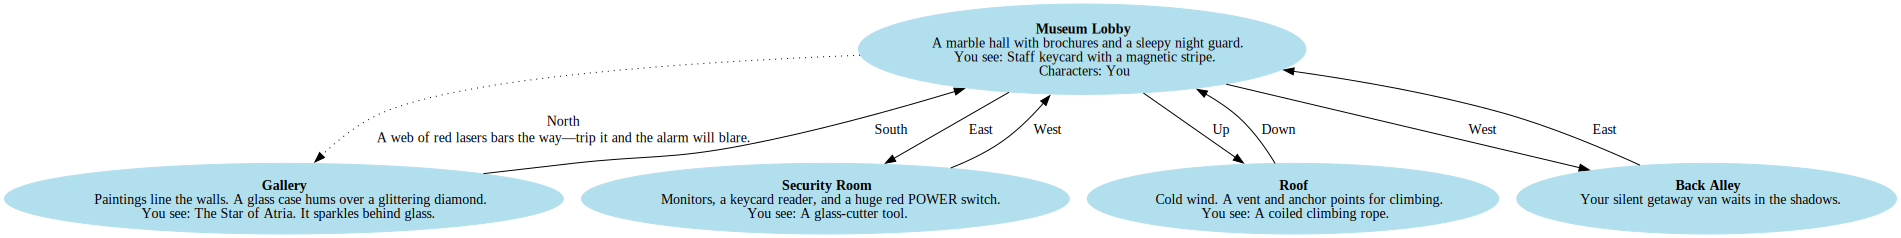

(Rendered with text_adventure_games.viz.Visualizer)


In [3]:
# === Cell: Game Map Visualizer (robust) ===
# Tries course viz first, then Graphviz, then ASCII adjacency.

def _list_rooms():
    # If you keep a list somewhere, use it; otherwise, derive from known vars
    rooms = []
    for name in ("lobby","gallery","security","roof","alley"):
        if name in globals():
            rooms.append(globals()[name])
    # Deduplicate while preserving order
    seen, out = set(), []
    for r in rooms:
        if id(r) not in seen:
            out.append(r); seen.add(id(r))
    return out

def _iter_exits(loc):
    # Return dict of direction -> destination Location
    ex = {}
    if hasattr(loc, "exits") and isinstance(loc.exits, dict):
        ex = loc.exits
    elif hasattr(loc, "get_exits"):
        try:
            maybe = loc.get_exits()
            if isinstance(maybe, dict):
                ex = maybe
        except Exception:
            pass
    return ex or {}

rooms = _list_rooms()

# 1) Try the course-provided visualizer
try:
    from text_adventure_games.viz import Visualizer as _Visualizer
    vis = _Visualizer(game)
    g = vis.visualize()  # returns a graphviz.Source/Graph
    display(g)
    print("(Rendered with text_adventure_games.viz.Visualizer)")
except Exception as e1:
    print("Course Visualizer unavailable or failed:", e1)

    # 2) Try plain Graphviz (python package + 'dot' executable)
    try:
        import shutil
        import graphviz
        if shutil.which("dot") is None:
            raise RuntimeError("Graphviz 'dot' executable not found on PATH.")
        dot = graphviz.Digraph("MuseumHeist", format="png", graph_attr={"rankdir":"LR"})
        # nodes
        for r in rooms:
            dot.node(getattr(r, "name", f"Room_{id(r)}"), getattr(r, "name", "Room"))
        # edges with direction labels
        for r in rooms:
            rname = getattr(r, "name", f"Room_{id(r)}")
            for d, dest in _iter_exits(r).items():
                dname = getattr(dest, "name", f"Room_{id(dest)}")
                dot.edge(rname, dname, label=str(d))
        display(dot)
        print("(Rendered with python-graphviz)")
    except Exception as e2:
        print("Graphviz fallback failed:", e2)

        # 3) ASCII fallback
        print("\nASCII Map (adjacency):")
        for r in rooms:
            print(f"- {getattr(r,'name','Room')}")
            ex = _iter_exits(r)
            if ex:
                for d, dest in ex.items():
                    print(f"    --{d}--> {getattr(dest,'name','Room')}")
            else:
                print("    (no exits)")


In [ ]:
game.game_loop()

Your silent getaway van waits in the shadows.
Exits:
East to Museum Lobby




